# Comparison between Climate models and HYRAS dataset per GWL well

Understanding the correlations between the projected meteorological parameters given by the regional climate models and the historical values, is key to approach the uncertainties related with the GWL projections. This is mainly due to the fact that CNNs models are calibrated with the historical values to then used them together with the projected variables.

In [48]:
#import libraries
%matplotlib notebook
import geopandas as gpd
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import os
from functions import setinputdataset
#from statsmodels.tsa.seasonal import seasonal_decompose
#from scipy.stats import linregress
import numpy as np
#from matplotlib_scalebar.scalebar import ScaleBar
#import matplotlib.colors as colors
#import contextily as cx
#from mpl_toolkits.axes_grid1 import make_axes_locatable
from functions import mapplot
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [11]:
def load_GW_and_HYRAS_Data(i):
    #define where to find the data
    path="D:/Data/students/mariana/data/"
    datagw=pd.read_pickle(path+"/Pickle/GWfilldatamod2.pkl")

    datapr=pd.read_pickle(path+"/Pickle/dataprt.pkl")
    datatm=pd.read_pickle(path+"/Pickle/datatmt.pkl")
    datarh=pd.read_pickle(path+"/Pickle/datarht.pkl")
    
    Well_ID=str(datagw.wellid[i])
    data=setinputdataset(Well_ID,datagw)
    dfwell=data.setinputdata(datapr, datatm, datarh)
    dfw=dfwell.set_index("dates")
    
    return  dfw[dfw.columns[:-1]], Well_ID

In [30]:
def load_GW_and_CM_Data(i,projname):
    #define where to find the data
    path="D:/Data/students/mariana/data/"
    datagw=pd.read_pickle(path+"/Pickle/GWfilldatamod.pkl")

    cmpr=pd.read_pickle(path+"/Pickle/cmprdf.pkl")
    cmtm=pd.read_pickle(path+"/Pickle/cmtmdf.pkl")
    cmrh=pd.read_pickle(path+"/Pickle/cmrhdf.pkl")
    
    Well_ID=str(datagw.wellid[i])
    data=setinputdataset(Well_ID,datagw)
    # Include only CM data that overlaps with GWL 
    dfwell=data.setclimmodel(cmpr, cmtm, cmrh, modelname=projname, allcm=False) 
    dfw=dfwell.set_index("dates")
    
    return  dfw[dfw.columns[:-1]], Well_ID

In [35]:
Projection_name = ["MPI_WRF361H", "MPI_CCLM", "MIROC_CCLM", 
         "HadGEM_WRF361H", "ECE_RACMO_r12", "ECE_RACMO_r1"]

In [66]:
i=0
hyrasdf, wellid= load_GW_and_HYRAS_Data(i)
cmdfs=[]
for projname in Projection_name:
    cmdf, wellid= load_GW_and_CM_Data(i, projname)
    cmdfcomp=cmdf.loc[cmdf.index<=hyrasdf.index[-1]]
    cmdfs.append(cmdfcomp)
    

In [67]:
cmdfcomp=cmdf.loc[cmdf.index<=hyrasdf.index[-1]]
hyrasdfcomp=hyrasdf.loc[hyrasdf.index>=cmdf.index[0]]

<IPython.core.display.Javascript object>


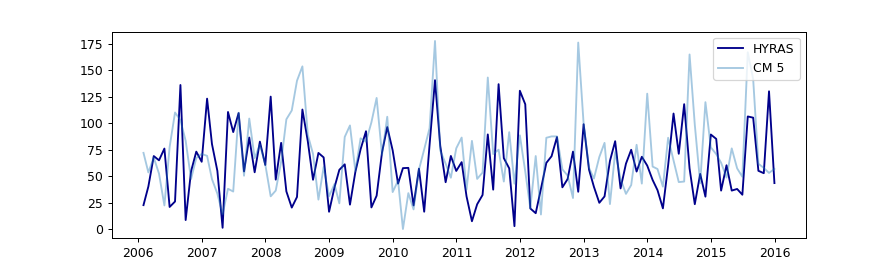

In [78]:
plt.figure(figsize=(10,3))
plt.plot(hyrasdfcomp.index,hyrasdfcomp['pr'],label='HYRAS',color='darkblue')
#for n in range(len(Projection_name)):
plt.plot(cmdfs[n].index,cmdfs[n]['pr'],label='CM '+str(n),alpha=0.4)
plt.legend(loc=1)

In [85]:
var='pr'
r2s=[]
for i in range(5):
    hyrasdf, wellid= load_GW_and_HYRAS_Data(i)
    hyrasdfcomp=hyrasdf.loc[hyrasdf.index>=cmdf.index[0]]
    for projname in Projection_name:
        cmdf, wellid= load_GW_and_CM_Data(i, projname)
        cmdfcomp=cmdf.loc[cmdf.index<=hyrasdf.index[-1]]

        simval=cmdfcomp[var].values
        obstestp= hyrasdfcomp[var].values

        sim = np.asarray(simval.reshape(-1,1))
        obs = np.asarray(obstestp.reshape(-1,1))

        err = sim-obs
        err_rel = (sim-obs)/(np.max(hyrasdf[var])-np.min(hyrasdf[var]))
        err_nash = obs - np.mean(obs)

        NSE = 1 - ((np.sum(err ** 2)) / (np.sum((err_nash) ** 2)))
        r = stats.linregress(sim[:,0], obs[:,0])
        R2 = r.rvalue ** 2
        RMSE =  np.sqrt(np.mean(err ** 2))
        rRMSE = np.sqrt(np.mean(err_rel ** 2)) * 100
        Bias = np.mean(err)
        rBias = np.mean(err_rel) * 100


        scores = pd.DataFrame(np.array([[NSE, R2, RMSE, rRMSE, Bias, rBias]]),
                       columns=['NSE','R2','RMSE','rRMSE','Bias','rBias'])
        r2s.append(R2)
        #print(wellid)
        print(str(wellid)+', r2 '+str(R2))
        print(scores)


9610009, r2 0.03079077882410534
        NSE        R2       RMSE     rRMSE      Bias     rBias
0 -0.476254  0.030791  45.726879  19.93687 -3.930984 -1.713905
9610009, r2 0.05824484366566249
        NSE        R2      RMSE      rRMSE      Bias     rBias
0 -0.334133  0.058245  43.47009  18.952912  1.494979  0.651809
9610009, r2 0.004620150355923439
        NSE       R2       RMSE      rRMSE      Bias     rBias
0 -0.746715  0.00462  49.739571  21.686399 -4.270457 -1.861915
9610009, r2 0.00449741071643158
        NSE        R2       RMSE      rRMSE      Bias     rBias
0 -0.923054  0.004497  52.189937  22.754756  2.973492  1.296439
9610009, r2 0.03378113556956449
        NSE        R2       RMSE      rRMSE      Bias     rBias
0 -0.467055  0.033781  45.584188  19.874657  1.536002  0.669695
9610009, r2 0.039479221622130384
        NSE        R2       RMSE      rRMSE      Bias     rBias
0 -0.498933  0.039479  46.076786  20.089429  4.370793  1.905661
9610749, r2 0.025778763016422686
        NSE

In [84]:
stats.linregress(simval,obstestp)

LinregressResult(slope=0.13256973992848234, intercept=51.47160548632081, rvalue=0.1456775263222622, pvalue=0.11237781108250011, stderr=0.08288061305982372, intercept_stderr=6.336766323114594)